In [46]:
#step-1
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit#Importing the QuantumCircuit function from Qiskit. We will use this to create our quantum circuits!
from qiskit_aer import Aer
from qiskit.quantum_info import Operator
import numpy as np
backend = Aer.get_backend('qasm_simulator')
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session

# We will use these functions to run our circuit and visualize its final state
from qiskit.visualization import *

import warnings  # We are using this library to suppress some warning messages
warnings.filterwarnings("ignore")

service = QiskitRuntimeService()
print("Libraries imported successfully!")

qiskit_runtime_service.__init__:INFO:2024-04-20 04:37:59,276: Default instance: ibm-q/open/main


Libraries imported successfully!


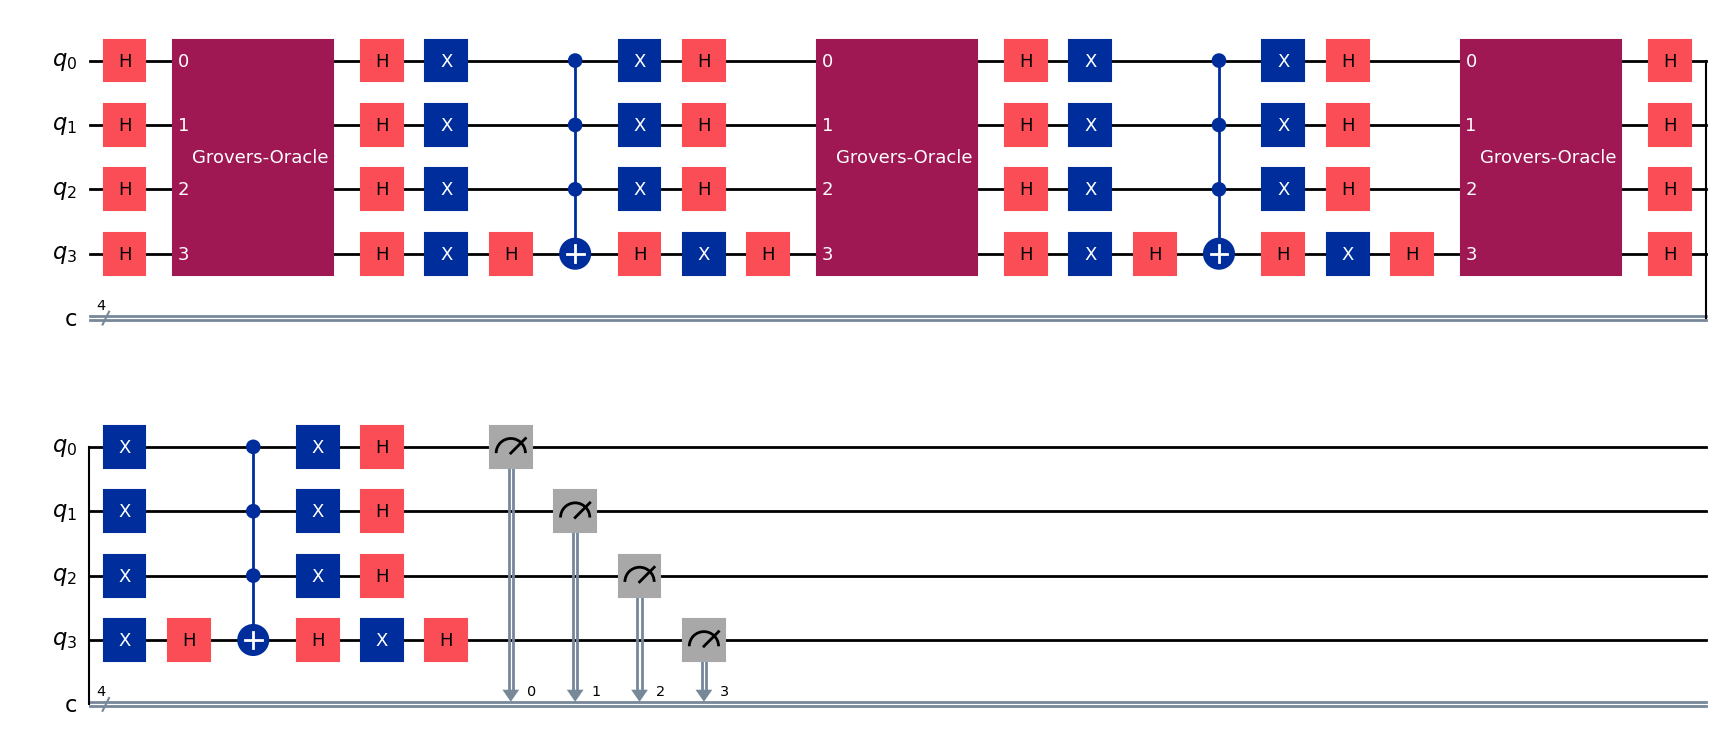

In [73]:
#step-2

def grovers_oracle(number_qubits, desired_target_state):
    #Creates a Grover oracle for the given desired_target_state.
    
    # Creates a circuit with number_qubits needed to represent the quantum circuit
    grovers_oracle = QuantumCircuit(number_qubits)  
    
    
    # creation of matrix to construct teh grovers_oracle below
    grovers_matrix= np.eye(2**number_qubits)                              
    
    grovers_matrix[desired_target_state, desired_target_state] = -1  # Applying a phase flip to the desired_target_state (phase inversion about mean is performed)
    
    # Converts the matrix to an operator and adds  to the circuits oracle
    groversoracle_gate = Operator(grovers_matrix)  #conversion of Operations to Gate
    grovers_oracle.unitary(groversoracle_gate, range(number_qubits), label="Grovers-Oracle") 
    
    return grovers_oracle

def grovers_diffuser(number_qubits):
    #Creates Grover diffuser for a given number of qubits.
    grovers_diffuser = QuantumCircuit(number_qubits)
    # Application  of  H, X, and CZ gates in order to construct the diffuser
    grovers_diffuser.h(range(number_qubits))
    grovers_diffuser.x(range(number_qubits))
    # Multi-controlled Z gate
    grovers_diffuser.h(number_qubits - 1)
    grovers_diffuser.mcx(list(range(number_qubits - 1)), number_qubits - 1)  
    grovers_diffuser.h(number_qubits - 1)
    grovers_diffuser.x(range(number_qubits))
    grovers_diffuser.h(range(number_qubits))
    
    return grovers_diffuser

def grovers_circuit(number_qubits, desired_target_state):
    #Creation  of complete grovers_circuit with desired_target_state that  we are interested in searching.
    quantum_circuit = QuantumCircuit(number_qubits, number_qubits)  #qc     
    
    # Intial step hadamard  gates is applied here.
    quantum_circuit.h(range(number_qubits))
    
    # Number of iterations is given by formula n  approximately equals to  pi/4 * sqrt(2^# of Qubits)
    iterations = int(np.floor(np.pi/4 * np.sqrt(2**number_qubits)))
    
    # Add the Grover oracle and diffuser
    for _ in range(iterations):
        quantum_circuit.compose(grovers_oracle(number_qubits, desired_target_state), range(number_qubits), inplace=True)
        quantum_circuit.compose(grovers_diffuser(number_qubits), range(number_qubits), inplace=True)
    
    # Measuring after phase inversion and number of iterations, so that basis state is comming closer to the desired search space here.
    quantum_circuit.measure(range(number_qubits), range(number_qubits))
    
    return quantum_circuit

# example usage is : 4-qubit Grover's search is shown below
number_qubits = 4
desired_target_state = 10  # binary logic 1110
grovers = grovers_circuit(number_qubits, desired_target_state)
grovers.draw('mpl')

base_primitive._run_primitive:INFO:2024-04-20 04:52:56,509: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


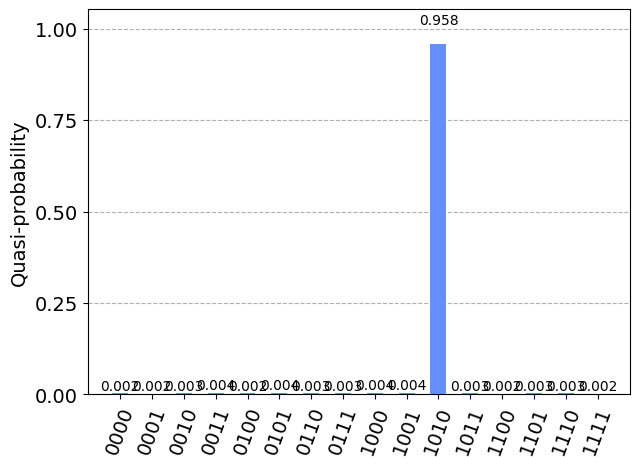

In [74]:
#step -3
# Simulate using Simulator
backend = service.get_backend('ibmq_qasm_simulator')

with Session(service = service, backend = backend) as session:
    sampler = Sampler()
    job = sampler.run(circuits =grovers)
    
job.result()    
plot_histogram(job.result().quasi_dists[0].binary_probabilities())